In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import itertools
import os

from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from tqdm.notebook import tqdm
from sklearn.linear_model import LogisticRegression

from src import *


torch.manual_seed(13)

In [3]:
torch.set_grad_enabled(False)

# Load Model

In [4]:
hf_model, hf_tokenizer = load_model_from_transformers("meta-llama/Llama-2-13b-chat-hf")
model = from_hf_to_tlens(hf_model, hf_tokenizer, f"llama-13b")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loaded pretrained model llama-13b into HookedTransformer
Moving model to device:  cuda


In [5]:
model.eval()

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (blocks): ModuleList(
    (0-39): 40 x TransformerBlock(
      (ln1): RMSNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): RMSNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
        (hook_rot_k): HookPoint()
        (hook_rot_q): HookPoint()
      )
      (mlp): GatedMLP(
        (hook_pre): HookPoint()
        (hook_pre_linear): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint(

# Setup Data

In [6]:
personas = {
    "lenient": "You are somewhat lenient on toxicity\n",
    "harsh": "You are somewhat harsh on toxicity\n",
    "very lenient": "You are very lenient on toxicity\n",
    "very harsh": "You are very harsh on toxicity\n",
    "somewhat lenient": "You are somewhat lenient on toxicity\n",
    "somewhat harsh": "You are somewhat harsh on toxicity\n",
}

possible_labels = ("CLEAN", "TOXIC")

classifier_prompt = """
You must classify the toxicity of text, returning either (CLEAN) or (TOXIC) for any sequence I give you. 

Here is the text:
{sequence}

Your response:
("""

In [7]:
toxicity_data = pd.read_json("data/simple_toxic_data_filtered.jsonl", lines=True)

In [8]:
dataset_path = "data/simple_toxic_data_filtered.jsonl"
our_task = Task(model, classifier_prompt, personas, possible_labels)
contrast_dataset = ConstrastTriplesDataset(model, our_task, dataset_path)
# eval_results = our_task.evaluate_personas_over_dataset(dataset_path, max_samples=None, version="v1.1")

# Load Representation

In [9]:
rep_folder = "aengus_das_results"
tox_dir = "DAS_inv-seq-False_inv-pers-True_subdim-1_Mar13-0517-52"
p_dir = "DAS_inv-seq-True_inv-pers-False_subdim-1_Mar13-1334-38"

In [56]:
layers_to_consider = list(range(10,21))
positions_to_consider = list(range(-7, 0))

toxicity_representations = defaultdict(dict)

for l in layers_to_consider:
    for p in positions_to_consider:
        toxicity_representations[l][p] = torch.load(f"{rep_folder}/{tox_dir}/linear_rep_{l}_{p}.pt").to(torch.bfloat16)

In [57]:
n = 30
toxicity_representations_with_directions = defaultdict(dict)

caches = []
for sequence in toxicity_data[toxicity_data["label"] == "toxic"][:n]:
    full_prompt = personas["harsh"] + classifier_prompt.format(sequence=sequence)
    logits, cache = model.run_with_cache(full_prompt)
    caches.append(cache)

for l in layers_to_consider:
    for p in positions_to_consider:
            toxic_scores = []
            rep = toxicity_representations[l][p][0]
            for cache in caches:
                acts = cache[f"blocks.{l}.hook_resid_mid"]
                toxic_score = (torch.nn.functional.normalize(acts[0, p], dim=0) @ torch.nn.functional.normalize(rep, dim=0)).item()
                toxic_scores.append(toxic_score)

            direction = 1 if np.mean(toxic_scores) < 0 else -1  # direction is positive if mean toxic score of toxic sequences is negative

            toxicity_representations_with_directions[l][p] = (toxicity_representations[l][p][0], direction)

del caches


In [11]:
layers_to_consider = range(10,17)
positions_to_consider = range(-7, 0)

persona_representations = defaultdict(dict)

for l in layers_to_consider:
    for p in positions_to_consider:
        persona_representations[l][p] = torch.load(f"{rep_folder}/{p_dir}/linear_rep_{l}_{p}.pt").to(torch.bfloat16)

In [19]:
torch.cuda.empty_cache()

In [18]:
n = 30
persona_representations_with_directions = defaultdict(dict)

caches = []
for sequence in toxicity_data["prompt"][:n]:
    full_prompt = personas["very lenient"] + classifier_prompt.format(sequence=sequence)
    logits, cache = model.run_with_cache(full_prompt)
    cache = cache.to("cpu")
    caches.append(cache)

for l in layers_to_consider:
    for p in positions_to_consider:
            persona_scores = []
            rep = persona_representations[l][p][0]
            for cache in caches:
                acts = cache[f"blocks.{l}.hook_resid_mid"]
                persona_score = (torch.nn.functional.normalize(acts[0, p], dim=0) @ rep.cpu()).item()
                persona_scores.append(persona_score)

            direction = 1 if np.mean(persona_scores) > 0 else -1  # direction is positive if mean persona score of very lenient persona sequences is positive

            persona_representations_with_directions[l][p] = (persona_representations[l][p][0], direction)

del caches


In [108]:
# # get bimodal distribution
# # We'll generate half the values from one normal distribution and the other half from another.

# # Generate 2560 values (half of 5120) from each normal distribution
# num_values = 5120
# mean1 = -0.015
# mean2 = 0.015
# std_dev = 0.01  # smaller standard deviation to create more distinct peaks

# # Generate two sets of random values
# random_tensor1 = torch.normal(mean=mean1, std=std_dev, size=(num_values // 2,))
# random_tensor2 = torch.normal(mean=mean2, std=std_dev, size=(num_values // 2,))

# # Combine into one tensor
# random_tensor = torch.cat((random_tensor1, random_tensor2))

# # Shuffle the tensor to mix the two distributions
# random_tensor = random_tensor[torch.randperm(random_tensor.size()[0])]
# # normalize
# random_tensor /= torch.norm(random_tensor, p=2)

In [109]:
# min_value = min([rep[0].min() for rep in representations.values()])
# max_value = max([rep[0].max() for rep in representations.values()])
# global_min = min(min_value, random_tensor.min())
# global_max = max(max_value, random_tensor.max())

# for positions, rep in representations.items():
#     plt.hist(rep[0].detach().cpu().numpy(), bins=np.linspace(global_min, global_max, 101), alpha=0.7, label=f"{positions}")

# plt.hist(random_tensor.detach().cpu().numpy(), bins=np.linspace(global_min, global_max, 101), alpha=0.7, label=f"random")
# plt.legend()


In [121]:

a = torch.tensor([1,2, 3])
print("a:", a.shape, a)
print("c:")
for _ in range(10):
    torch.manual_seed(13)
    b = torch.randperm(a.shape[0])
    c = a[b]

    print(c.shape, c)


a: torch.Size([3]) tensor([1, 2, 3])
c:
torch.Size([3]) tensor([2, 1, 3])
torch.Size([3]) tensor([2, 1, 3])
torch.Size([3]) tensor([2, 1, 3])
torch.Size([3]) tensor([2, 1, 3])
torch.Size([3]) tensor([2, 1, 3])
torch.Size([3]) tensor([2, 1, 3])
torch.Size([3]) tensor([2, 1, 3])
torch.Size([3]) tensor([2, 1, 3])
torch.Size([3]) tensor([2, 1, 3])
torch.Size([3]) tensor([2, 1, 3])


# Read Toxicity

In [58]:
def get_results(layers_to_consider, positions_to_consider, representations_with_directions, random_baseline=False):
    results = {l: {p: [] for p in positions_to_consider} for l in layers_to_consider}

    for sequence in tqdm(toxicity_data["prompt"][:100]):
        sequence_results = {l: {p: {} for p in positions_to_consider} for l in layers_to_consider}
        for persona in personas.keys():        
            full_prompt = personas[persona] + classifier_prompt.format(sequence=sequence)
            full_prompt_tokens = model.to_tokens(full_prompt)
            logits, cache = model.run_with_cache(full_prompt_tokens)
            ld = (logits[0, -1, 4986] - logits[0, -1, 29907]).item()

            probabilities = F.softmax(logits, dim=-1)
            prob_diff = (probabilities[0, -1, 4986] - probabilities[0, -1, 29907]).item()
            
            for layer in layers_to_consider:
                for pos in positions_to_consider:
                    rep, direction = representations_with_directions[layer][pos]
                    rep = direction * rep
                    if random_baseline:
                        torch.manual_seed(13)
                        rep = rep[torch.randperm(rep.shape[0])]

                    # (batch, seq, hidden_dim)
                    acts = cache[f"blocks.{layer}.hook_resid_mid"]
                    toxic_score = (torch.nn.functional.normalize(acts[0, pos], dim=0) @ torch.nn.functional.normalize(rep, dim=0)).item()
                    sequence_results[layer][pos][persona] = {"LD": ld, "toxic score": toxic_score, "prob diff": prob_diff}

        for l in layers_to_consider:
            for p in positions_to_consider:
                results[l][p].append(
                    {persona: sequence_results[l][p][persona] for persona in personas.keys()}
                )   

    return results

In [71]:
layers_to_consider = list(range(10,21))
positions_to_consider = list(range(-7, 0))
random_baseline_results = get_results(layers_to_consider, positions_to_consider, toxicity_representations_with_directions, random_baseline=True)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [02:03<00:00,  1.24s/it]


In [59]:
layers_to_consider = list(range(10,21))
positions_to_consider = list(range(-7, 0))
results = get_results(layers_to_consider, positions_to_consider, toxicity_representations_with_directions, random_baseline=False)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


In [45]:
layers_to_consider = list(range(10,21))
positions_to_consider = list(range(-7, 0))
# layers_to_consider = [14, 16, 18]
# positions_to_consider = [-7, -6, -1]


results = {l: {p: [] for p in positions_to_consider} for l in layers_to_consider}

for sequence in tqdm(toxicity_data["prompt"][:100]):
    sequence_results = {l: {p: {} for p in positions_to_consider} for l in layers_to_consider}
    for persona in personas.keys():        
        full_prompt = personas[persona] + classifier_prompt.format(sequence=sequence)
        full_prompt_tokens = model.to_tokens(full_prompt)
        logits, cache = model.run_with_cache(full_prompt_tokens)
        ld = (logits[0, -1, 4986] - logits[0, -1, 29907]).item()
        persona_results = {}

        probabilities = F.softmax(logits, dim=-1)
        prob_diff = (probabilities[0, -1, 4986] - probabilities[0, -1, 29907]).item()
        
        for layer in layers_to_consider:
            for pos in positions_to_consider:
                rep, direction = toxicity_representations_with_directions[layer][pos]

                # (batch, seq, hidden_dim)
                acts = cache[f"blocks.{layer}.hook_resid_mid"]
                toxic_score = direction (torch.nn.functional.normalize(acts[0, pos], dim=0) @ torch.nn.functional.normalize(rep, dim=0)).item()
                sequence_results[layer][pos][persona] = {"LD": ld, "toxic score": toxic_score, "prob diff": prob_diff}

    for l in layers_to_consider:
        for p in positions_to_consider:
            results[l][p].append(
                {persona: sequence_results[l][p][persona] for persona in personas.keys()}
            )   

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:52<00:00,  1.12s/it]


In [46]:
def create_toxicity_plot(results, title="Toxicity vs Logit Diff", y_axis="LD", y_label="Logit Diff"):
    plt.figure(figsize=(10, 6))

    for item in results:
        lenient = item['lenient']
        harsh = item['harsh']
        
        # Plotting points with different markers and colors
        plt.plot(lenient["toxic score"], lenient[y_axis], 'go', markersize=8)  # Green circle
        plt.plot(harsh["toxic score"], harsh[y_axis], '^', color='orange', markersize=8)  # Orange triangle
        # Connect points with a dotted line
        plt.plot([lenient["toxic score"], harsh["toxic score"]], [lenient[y_axis], harsh[y_axis]], 'k-', linestyle='dotted')
        

    # Adding legend entries by plotting empty lists
    plt.plot([], [], 'go', markersize=8, label='Lenient persona')
    plt.plot([], [], '^', color='orange', markersize=8, label='Harsh persona')
    plt.plot([], [], 'k:', label='Same sequence')
    plt.legend()

    # Setting the title and labels
    plt.title(title)
    plt.xlabel('Toxicity')
    plt.ylabel(y_label)

    # Adding a legend
    plt.legend()

    # Show grid for better visualization, optional
    plt.grid(True)

    # Display the plot
    plt.show()

In [61]:
persona_styles = {
    "very lenient": ("o", "blue"),
    # "lenient": ("o", "green"),
    "somewhat lenient": ("o", "green"),
    "somewhat harsh": ("^", "orange"),
    # "harsh": ("^", "orange"),
    "very harsh": ("^", "red"),
}

persona_keys = ["very lenient", "somewhat lenient", "somewhat harsh", "very harsh"]


def create_toxicity_plot_multiple_personas(results, title="Toxicity vs Logit Diff", y_axis="LD", y_label="Logit Diff"):
    plt.figure(figsize=(12, 8))

    for item in results:
        for persona in persona_keys:
            marker, color = persona_styles[persona]
            plt.plot(item[persona]["toxic score"], item[persona][y_axis], marker, color=color, markersize=8)
            for p1, p2 in zip(persona_keys, persona_keys[1:]):
                plt.plot([item[p1]["toxic score"], item[p2]["toxic score"]], [item[p1][y_axis], item[p2][y_axis]], 'k-', linestyle='dotted')
        

    # Adding legend entries by plotting empty lists
    for persona, (marker, color) in persona_styles.items():
        plt.plot([], [], marker, color=color, markersize=8, label=persona) 
    plt.plot([], [], 'k:', label='Same sequence')
    plt.legend()

    # Setting the title and labels
    plt.title(title)
    plt.xlabel('Toxicity')
    plt.ylabel(y_label)

    # Adding a legend
    plt.legend()

    # Show grid for better visualization, optional
    plt.grid(True)

    # Display the plot
    plt.show()

In [24]:
def bin_results(results, bin_count=100):

    # Extract all toxic scores to determine the overall min and max
    toxic_scores = [item[condition]['toxic score'] for item in results for condition in ['lenient', 'harsh']]
    min_toxic_score = min(toxic_scores)
    max_toxic_score = max(toxic_scores)

    # Define the bin edges - calculate the width of each bin first
    bin_width = (max_toxic_score - min_toxic_score) / bin_count
    bins = [min_toxic_score + i*bin_width for i in range(bin_count + 1)]

    # Assign dictionaries to bins based on their toxic scores
    bins_dict = {i: [] for i in range(bin_count)}

    for item in results:
        toxic_score = item["lenient"]["toxic score"]
        # Determine which bin this score falls into
        bin_index = int((toxic_score - min_toxic_score) // bin_width)
        bin_index = min(bin_index, bin_count - 1)  # Ensure it does not go out of the range
        bins_dict[bin_index].append(item)

    return bins_dict

/tmp/ipykernel_1588/2835997917.py:12: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot([lenient["toxic score"], harsh["toxic score"]], [lenient[y_axis], harsh[y_axis]], 'k-', linestyle='dotted')


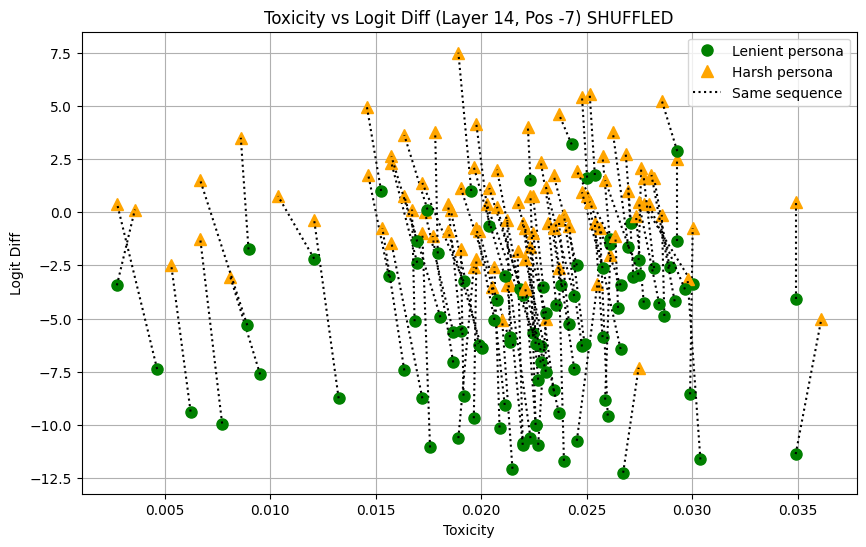

In [127]:
create_toxicity_plot(results[-7], title="Toxicity vs Logit Diff (Layer 14, Pos -7) SHUFFLED", y_axis="LD", y_label="Logit Diff")

/tmp/ipykernel_1588/2835997917.py:12: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot([lenient["toxic score"], harsh["toxic score"]], [lenient[y_axis], harsh[y_axis]], 'k-', linestyle='dotted')


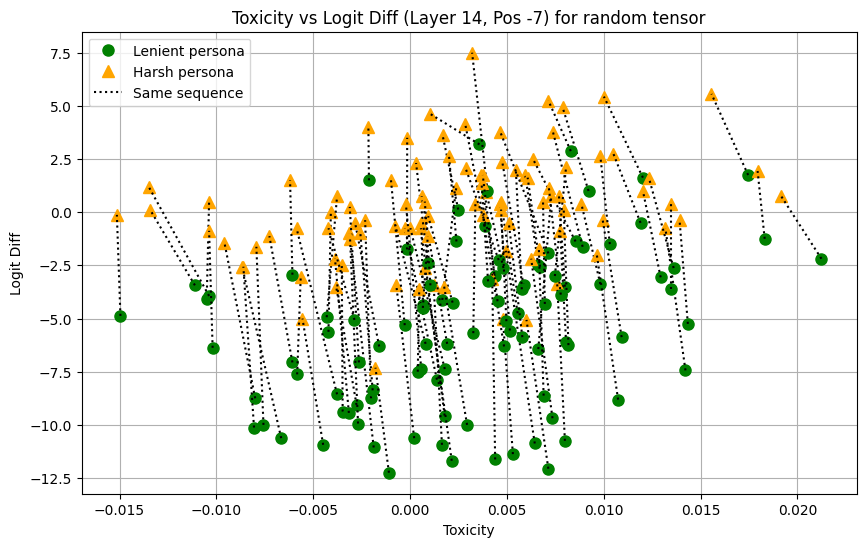

In [74]:
create_toxicity_plot(results[-7], title="Toxicity vs Logit Diff (Layer 14, Pos -7) for random tensor", y_axis="LD", y_label="Logit Diff")

/tmp/ipykernel_7543/2835997917.py:12: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot([lenient["toxic score"], harsh["toxic score"]], [lenient[y_axis], harsh[y_axis]], 'k-', linestyle='dotted')


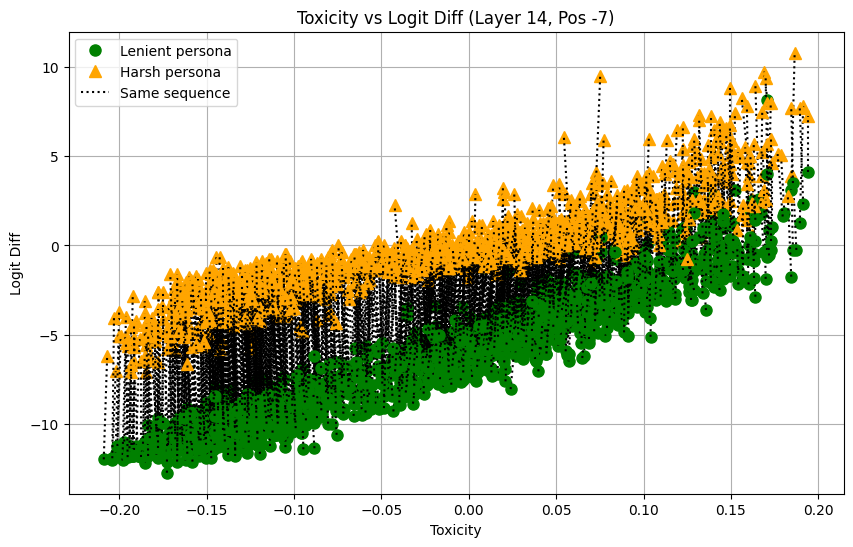

In [57]:
create_toxicity_plot(results[-7], title="Toxicity vs Logit Diff (Layer 14, Pos -7)", y_axis="LD", y_label="Logit Diff")

/tmp/ipykernel_7316/2131146368.py:21: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot([item[p1]["toxic score"], item[p2]["toxic score"]], [item[p1][y_axis], item[p2][y_axis]], 'k-', linestyle='dotted')


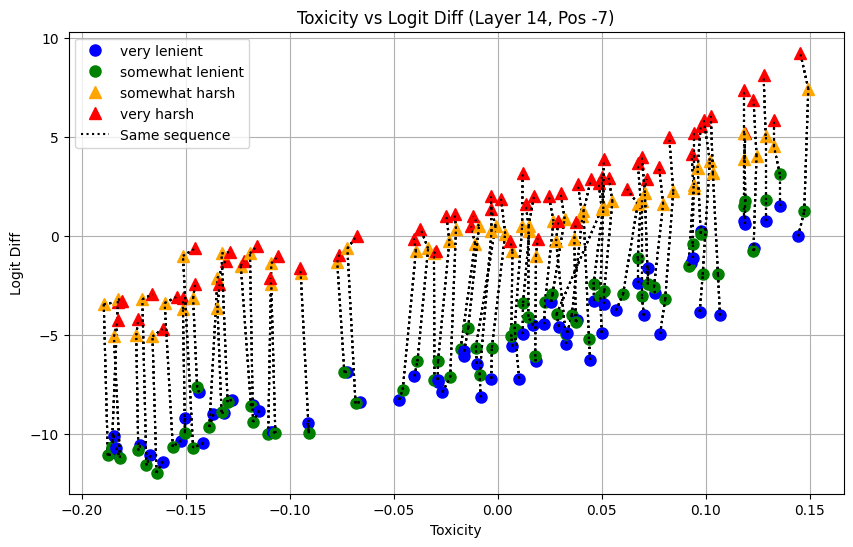

In [62]:
bins_dict = bin_results(results[14][-7])
binned_results = [bins_dict[i][0] for i in range(len(bins_dict)) if len(bins_dict[i]) > 0]

create_toxicity_plot_multiple_personas(binned_results, title="Toxicity vs Logit Diff (Layer 14, Pos -7)", y_axis="LD", y_label="Logit Diff")

/tmp/ipykernel_43289/3727453988.py:21: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot([item[p1]["toxic score"], item[p2]["toxic score"]], [item[p1][y_axis], item[p2][y_axis]], 'k-', linestyle='dotted')


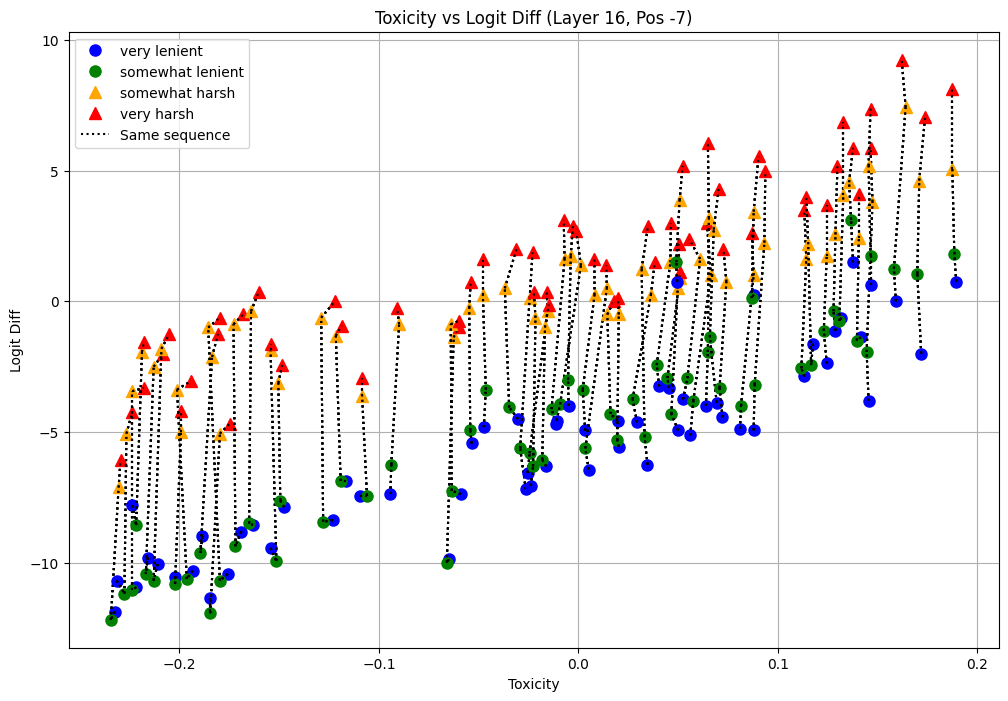

In [62]:
bins_dict = bin_results(results[16][-7])
binned_results = [bins_dict[i][0] for i in range(len(bins_dict)) if len(bins_dict[i]) > 0]

create_toxicity_plot_multiple_personas(binned_results, title="Toxicity vs Logit Diff (Layer 16, Pos -7)", y_axis="LD", y_label="Logit Diff")

/tmp/ipykernel_7316/2131146368.py:21: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot([item[p1]["toxic score"], item[p2]["toxic score"]], [item[p1][y_axis], item[p2][y_axis]], 'k-', linestyle='dotted')


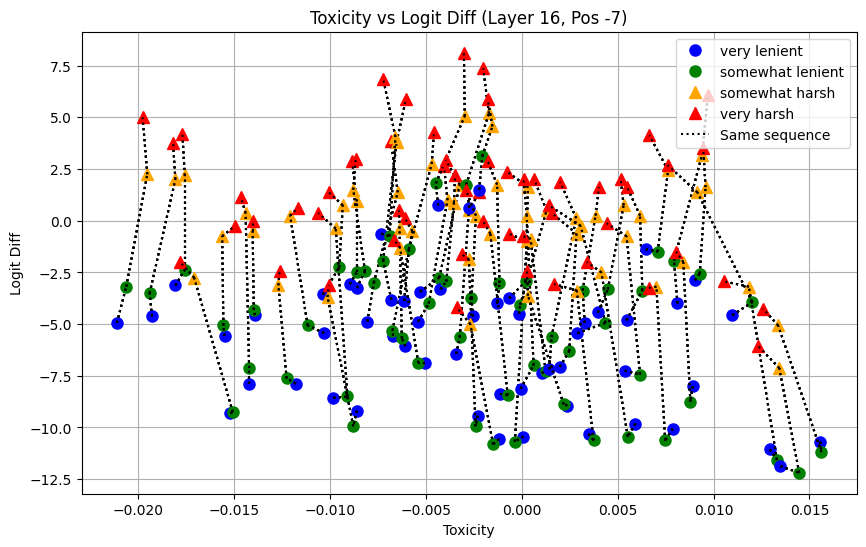

In [72]:
bins_dict = bin_results(random_baseline_results[16][-7])
binned_results = [bins_dict[i][0] for i in range(len(bins_dict)) if len(bins_dict[i]) > 0]

create_toxicity_plot_multiple_personas(binned_results, title="Toxicity vs Logit Diff (Layer 16, Pos -7)", y_axis="LD", y_label="Logit Diff")

/tmp/ipykernel_7316/2835997917.py:12: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot([lenient["toxic score"], harsh["toxic score"]], [lenient[y_axis], harsh[y_axis]], 'k-', linestyle='dotted')


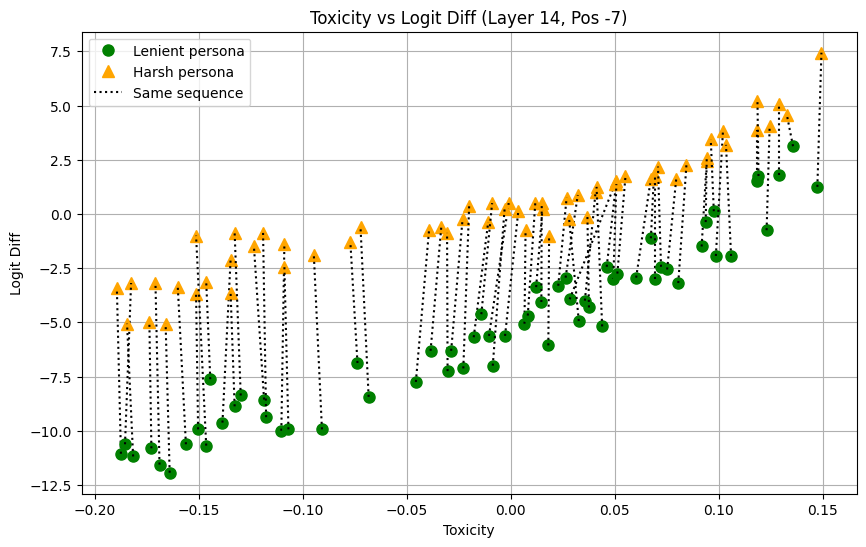

In [48]:
bins_dict = bin_results(results[14][-7])
binned_results = [bins_dict[i][0] for i in range(len(bins_dict)) if len(bins_dict[i]) > 0]

create_toxicity_plot(binned_results, title="Toxicity vs Logit Diff (Layer 14, Pos -7)", y_axis="LD", y_label="Logit Diff")

/tmp/ipykernel_7316/2835997917.py:12: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot([lenient["toxic score"], harsh["toxic score"]], [lenient[y_axis], harsh[y_axis]], 'k-', linestyle='dotted')


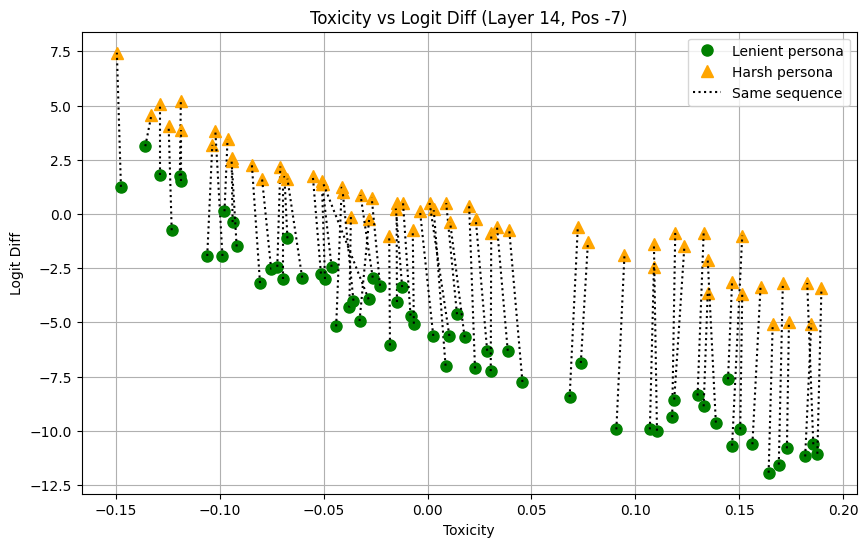

In [40]:
bins_dict = bin_results(results[14][-7])
binned_results = [bins_dict[i][0] for i in range(len(bins_dict)) if len(bins_dict[i]) > 0]

create_toxicity_plot(binned_results, title="Toxicity vs Logit Diff (Layer 14, Pos -7)", y_axis="LD", y_label="Logit Diff")

/tmp/ipykernel_7543/2835997917.py:12: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot([lenient["toxic score"], harsh["toxic score"]], [lenient[y_axis], harsh[y_axis]], 'k-', linestyle='dotted')


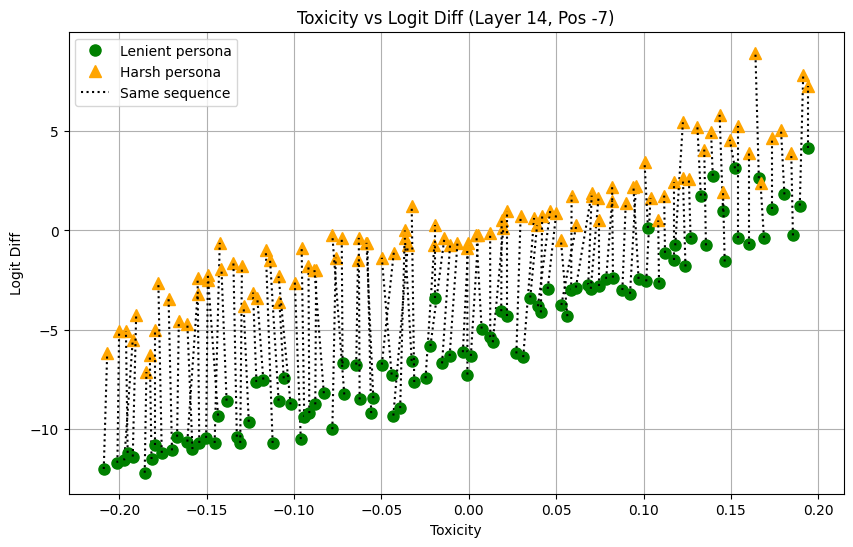

In [60]:
bins_dict = bin_results(results[-7])
binned_results = [bins_dict[i][0] for i in range(len(bins_dict)) if len(bins_dict[i]) > 0]

create_toxicity_plot(binned_results, title="Toxicity vs Logit Diff (Layer 14, Pos -7)", y_axis="LD", y_label="Logit Diff")

/tmp/ipykernel_7543/2835997917.py:12: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot([lenient["toxic score"], harsh["toxic score"]], [lenient[y_axis], harsh[y_axis]], 'k-', linestyle='dotted')


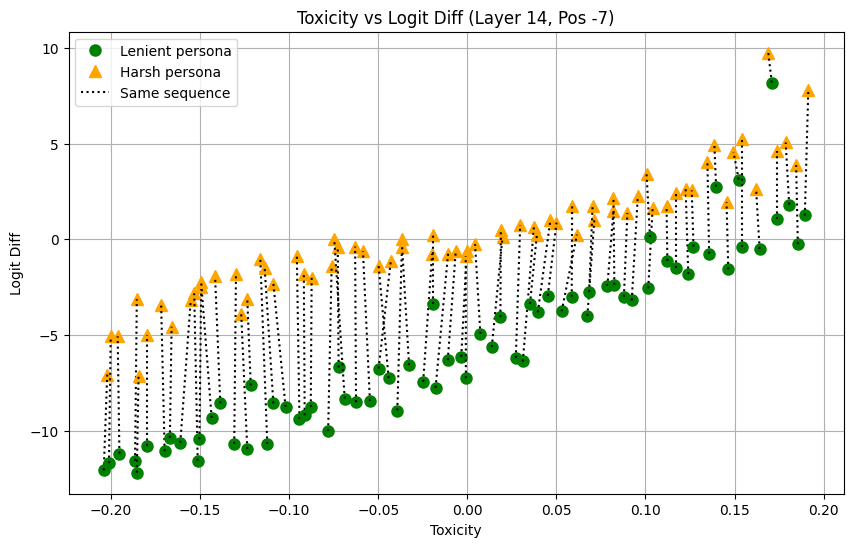

In [62]:
bins_dict = bin_results(results[-7], bin_count=70)
binned_results = [bins_dict[i][0] for i in range(len(bins_dict)) if len(bins_dict[i]) > 0]

create_toxicity_plot(binned_results, title="Toxicity vs Logit Diff (Layer 14, Pos -7)", y_axis="LD", y_label="Logit Diff")

/tmp/ipykernel_7543/2835997917.py:12: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot([lenient["toxic score"], harsh["toxic score"]], [lenient[y_axis], harsh[y_axis]], 'k-', linestyle='dotted')


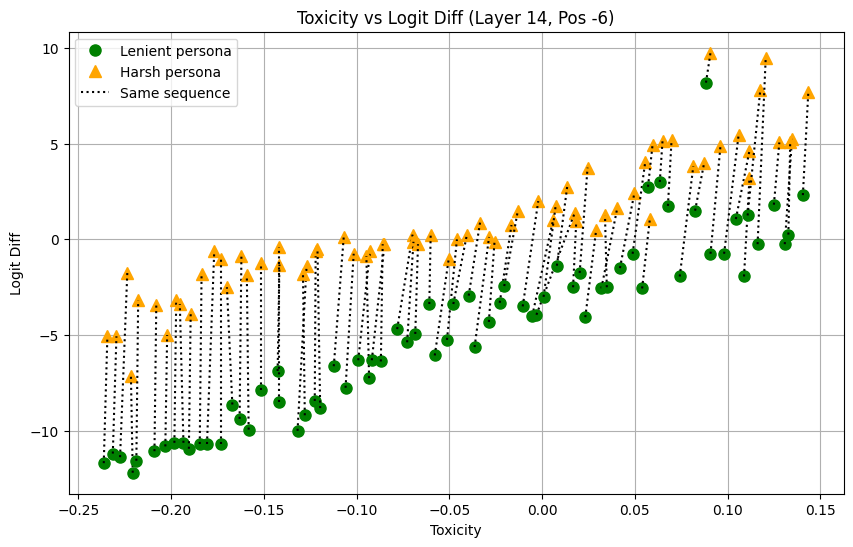

In [63]:
bins_dict = bin_results(results[-6], bin_count=70)
binned_results = [bins_dict[i][0] for i in range(len(bins_dict)) if len(bins_dict[i]) > 0]

create_toxicity_plot(binned_results, title="Toxicity vs Logit Diff (Layer 14, Pos -6)", y_axis="LD", y_label="Logit Diff")

In [65]:
results.keys()

dict_keys([-7, -6, 1, -1])

In [64]:
bins_dict = bin_results(results[-1], bin_count=70)
binned_results = [bins_dict[i][0] for i in range(len(bins_dict)) if len(bins_dict[i]) > 0]

create_toxicity_plot(binned_results, title="Toxicity vs Logit Diff (Layer 14, Pos -1)", y_axis="LD", y_label="Logit Diff")

ValueError: min() arg is an empty sequence

/tmp/ipykernel_7543/2131242649.py:12: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot([lenient["toxic score"], harsh["toxic score"]], [lenient[y_axis], harsh[y_axis]], 'k-', linestyle='dotted')


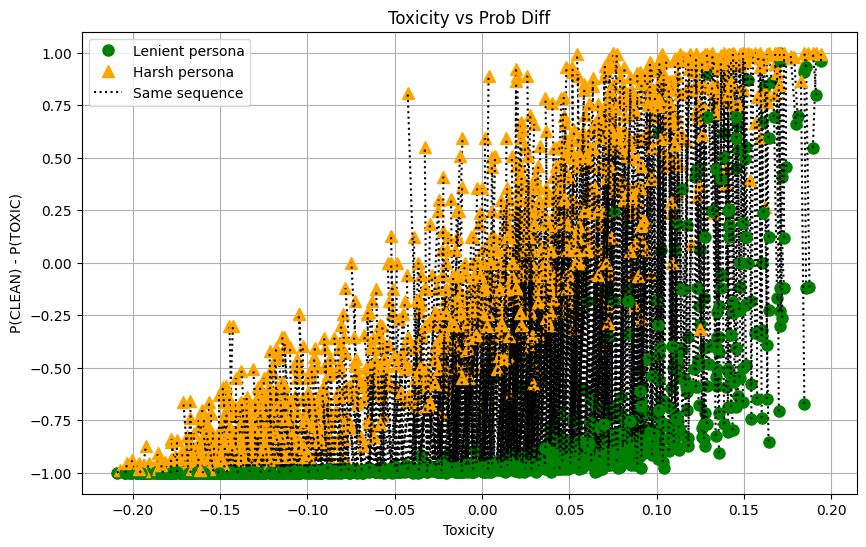

In [40]:
create_toxicity_plot(results, pos=-7, title="Toxicity vs Prob Diff", y_axis="prob diff", y_label="P(CLEAN) - P(TOXIC)")

/tmp/ipykernel_7543/613617034.py:11: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot([lenient["toxic score"], harsh["toxic score"]], [lenient["LD"], harsh["LD"]], 'k-', linestyle='dotted')


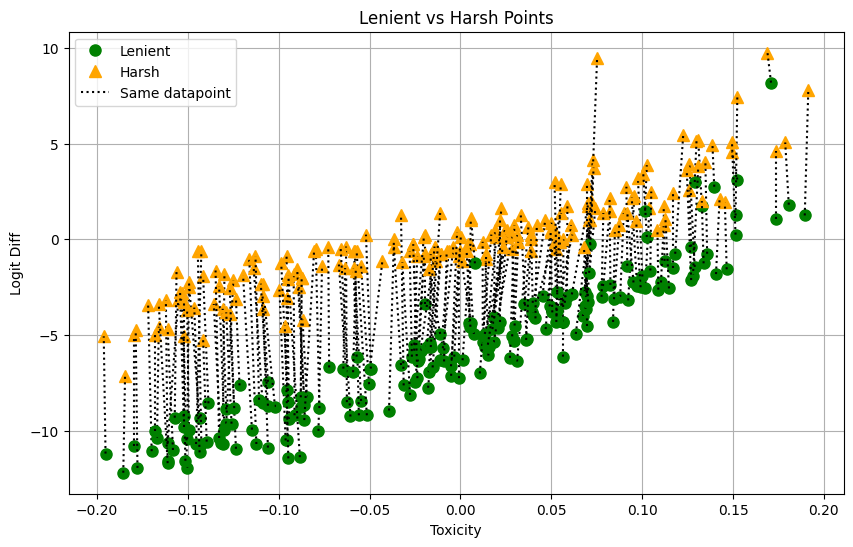

In [36]:
plt.figure(figsize=(10, 6))

for item in results[-7]:
    lenient = item['lenient']
    harsh = item['harsh']
    
    # Plotting points with different markers and colors
    plt.plot(lenient["toxic score"], lenient["LD"], 'go', markersize=8)  # Green circle
    plt.plot(harsh["toxic score"], harsh["LD"], '^', color='orange', markersize=8)  # Orange triangle
    # Connect points with a dotted line
    plt.plot([lenient["toxic score"], harsh["toxic score"]], [lenient["LD"], harsh["LD"]], 'k-', linestyle='dotted')
    

# Adding legend entries by plotting empty lists
plt.plot([], [], 'go', markersize=8, label='Lenient')
plt.plot([], [], '^', color='orange', markersize=8, label='Harsh')
plt.plot([], [], 'k:', label='Same datapoint')
plt.legend()

# Setting the title and labels
plt.title('Lenient vs Harsh Points')
plt.xlabel('Toxicity')
plt.ylabel('Logit Diff')

# Adding a legend
plt.legend()

# Show grid for better visualization, optional
plt.grid(True)

# Display the plot
plt.show()

# Plot Persona Stuff

In [43]:
def get_persona_results(layers_to_consider, positions_to_consider, persona_representations_with_directions, toxic_rep, toxic_rep_pos, toxic_rep_layer, random_baseline=False, n=100):
    # results = defaultdict(dict)
    results = {l: {p: defaultdict(list) for p in positions_to_consider} for l in layers_to_consider}

    for sequence in tqdm(toxicity_data["prompt"][:n]):
        for persona in personas.keys():        
            full_prompt = personas[persona] + classifier_prompt.format(sequence=sequence)
            full_prompt_tokens = model.to_tokens(full_prompt)
            logits, cache = model.run_with_cache(full_prompt_tokens)
            ld = (logits[0, -1, 4986] - logits[0, -1, 29907]).item()

            probabilities = F.softmax(logits, dim=-1)
            prob_diff = (probabilities[0, -1, 4986] - probabilities[0, -1, 29907]).item()
            
            acts = cache[f"blocks.{toxic_rep_layer}.hook_resid_mid"]
            toxic_score = (torch.nn.functional.normalize(acts[0, toxic_rep_pos], dim=0) @ toxic_rep).item()
            
            for layer in layers_to_consider:
                for pos in positions_to_consider:
                    persona_rep, direction = persona_representations_with_directions[layer][pos]
                    persona_rep = direction * persona_rep

                    persona_score = (torch.nn.functional.normalize(acts[0, pos], dim=0) @ torch.nn.functional.normalize(persona_rep, dim=0)).item()
                    results[layer][pos][persona].append({"LD": ld, "toxic score": toxic_score, "persona score": persona_score,"prob diff": prob_diff})

        # for l in layers_to_consider:
        #     for p in positions_to_consider:
        #         results[l][p].append(
        #             {persona: sequence_results[l][p][persona] for persona in personas.keys()}
        #         )   

    return results

In [21]:
layers_to_consider = range(10,17)
positions_to_consider = range(-7, 0)

In [46]:
toxic_rep = toxicity_representations_with_directions[16][-7][0]

persona_results = get_persona_results(layers_to_consider, positions_to_consider, persona_representations_with_directions, toxic_rep, -7, 16, random_baseline=False, n=10)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:10<00:00,  1.10s/it]


In [47]:
persona_styles = {
    "very lenient": ("o", "blue"),
    # "lenient": ("o", "green"),
    "somewhat lenient": ("o", "green"),
    "somewhat harsh": ("^", "orange"),
    # "harsh": ("^", "orange"),
    "very harsh": ("^", "red"),
}

persona_keys = ["very lenient", "somewhat lenient", "somewhat harsh", "very harsh"]


def create_plot(results, title="Toxicity vs Logit Diff", y_axis="LD", y_label="Logit Diff"):
    plt.figure(figsize=(10, 6))


    for persona in persona_keys:
        persona_results = results[persona]
        persona_results = sorted(persona_results, key=lambda x: x['toxic score'])

        for item in persona_results:
            plt.plot(item["persona score"], item[y_axis], "o", color=persona_styles[persona][1], markersize=8)

        for item1, item2 in zip(persona_results, persona_results[1:]):
            plt.plot([item1["persona score"], item2["persona score"]], [item1[y_axis], item2[y_axis]], 'k-', linestyle='dotted')

    plt.plot([], [], 'k:', label='Same persona')
    plt.legend()

    # Setting the title and labels
    plt.title(title)
    plt.xlabel('Persona')
    plt.ylabel(y_label)

    # Adding a legend
    plt.legend()

    # Show grid for better visualization, optional
    plt.grid(True)

    # Display the plot
    plt.show()

In [30]:
small_persona_results = {l: {p: {} for p in positions_to_consider} for l in layers_to_consider}

for l in layers_to_consider:
    for p in positions_to_consider:
        for persona in persona_keys:
            small_persona_results[l][p][persona] = persona_results[l][p][persona][:5]

In [35]:
persona_results[l][p].keys()

dict_keys(['lenient', 'harsh', 'very lenient', 'very harsh', 'somewhat lenient', 'somewhat harsh', 0, 1])

/tmp/ipykernel_43289/3069076714.py:25: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot([item1["persona score"], item2["persona score"]], [item1[y_axis], item2[y_axis]], 'k-', linestyle='dotted')


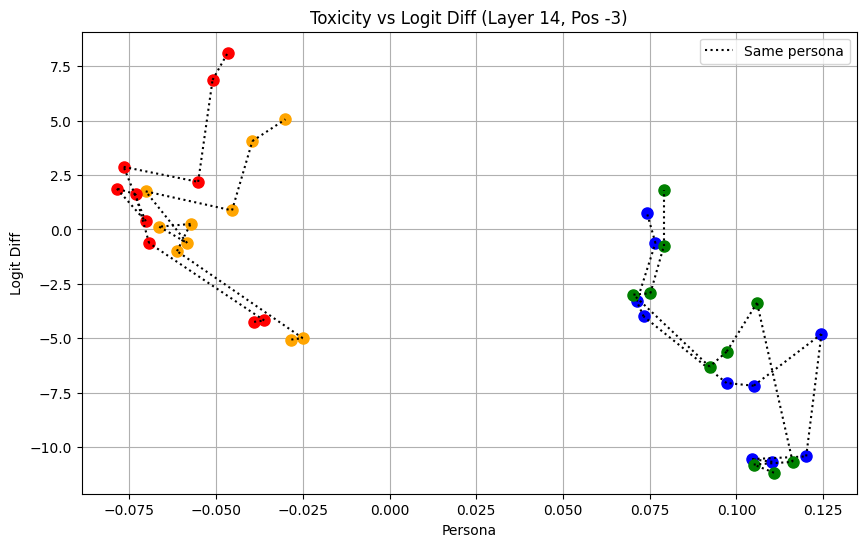

In [49]:
# bins_dict = bin_results(persona_results[15][-3])
# binned_results = [bins_dict[i][0] for i in range(len(bins_dict)) if len(bins_dict[i]) > 0]

create_plot(persona_results[14][-3], title="Toxicity vs Logit Diff (Layer 14, Pos -3)", y_axis="LD", y_label="Logit Diff")